## Introduction

In this project, we'll be working with a data set that contains 80000 board games and their associated review scores. The data was scraped from BoardGameGeek and compiled into CSV format by [Sean Beck](https://github.com/ThaWeatherman). The data set is stored in board_games.csv.

Each row represents a single board game, and has descriptive statistics about the board game, as well as review information. Here are some of the interesting columns:

- name: name of the board game.
- playingtime: the playing time (given by the manufacturer).
- minplaytime: the minimum playing time (given by the manufacturer).
- maxplaytime: the maximum playing time (given by the manufacturer).
- minage: the minimum recommended age to play.
- users_rated: the number of users who rated the game.
- average_rating: the average rating given to the game by users. (0-10)
- total_weights: Number of weights given by users. Read more about what BoardGameGeek considers weights [here](http://boardgamegeek.com/wiki/page/Weight).
- average_weight: the average of all the subjective weights (0-5).

In [1]:
import pandas as pd

board_games = pd.read_csv("board_games.csv")
board_games = board_games.dropna(axis=0)
board_games = board_games[board_games["users_rated"] > 0]

board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


## Picking An Error Metric

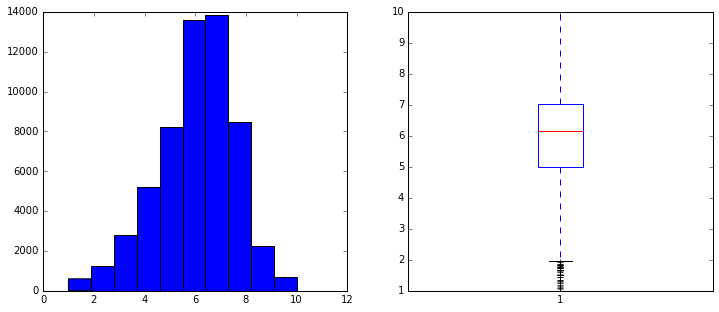

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(board_games["average_rating"])
ax2.boxplot(board_games["average_rating"])
plt.show()

In [3]:
print(board_games["average_rating"].std())
print(board_games["average_rating"].mean())

1.57882993483
6.01611284933


### Findings so far:

Looking at how the data is continuous and is almost normally distributed, using mean squared error as an error metric would make sense.

## Plotting Clusters

In [4]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=5)
numeric_columns = board_games.ix[:,3:]
clusters.fit(numeric_columns)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [5]:
labels = clusters.labels_

import numpy as np
game_mean = numeric_columns.apply(np.mean, axis=1)
game_std = numeric_columns.apply(np.std, axis=1)

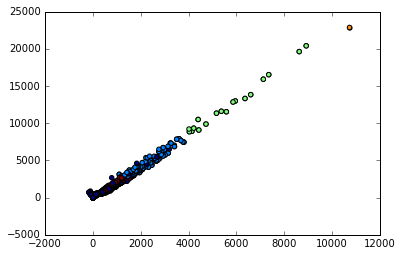

In [6]:
plt.scatter(game_mean, game_std, c = labels)
plt.show()

### Findings so far:

It appears that most of games are seldom played, but there a few that have a lot of players which attributes to a higher rating for those games.

## Finding Correlations

In [7]:
correlations = numeric_columns.corr()

correlations["average_rating"]

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

### Findings so far:

Looking at the **yearpublished** column, it appears that the more recent the game is released, the higher the ratings. 

The higher the minimum age of a game (**minage**), the higher the rating. This could mean that if the players age is higher, there is a higher chance that they leave a review.

Similarly, the more "weighty" a game is (**average_weight**), the more highly it tends to be rated.

In [8]:
numeric_columns.drop("average_rating", axis=1, inplace=True)
numeric_columns.drop("bayes_average_rating", axis=1, inplace=True)

## Creating a Model

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(numeric_columns, board_games["average_rating"])
predictions = reg.predict(numeric_columns)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions, board_games["average_rating"])
print(mse)

2.09339697583


### Findings:

Seeing as how the mean squared error rate is close to the standard deviation of all board game ratings, this indicates that our model may not have high predictive power. We'll need to dig more into which games were scored well, and which ones weren't.